In [0]:
# install imgaug for augmentation in training, skip if no training is required
!pip3 install imgaug

# install torch for training and inference
!pip3 install torch torchvision

# install OCR packages
!pip install pytesseract
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

In [2]:
!mkdir results -p
!mkdir temp_images -p

In [0]:
!unzip train_val.zip

1040


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils, datasets
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import PIL

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# Load folder into torch dataset

In [2]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 2.0))),
            iaa.ContrastNormalization((0.75, 1.5)),
            iaa.AddToHueAndSaturation((-20, 20), per_channel=True),
            iaa.OneOf([iaa.MultiplyElementwise((0.5, 1.5)),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.2*255), per_channel=0.5)]),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout((0.0, 0.1), size_percent=(0.02, 0.25))])),
#             iaa.PiecewiseAffine(scale=(0.01, 0.05)), # takes lots of time
#             iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True), # only for colored images
            iaa.Sometimes(0.5, iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-20, 20),
                shear=(-8, 8)
            ))
        ], random_order=True)
      
    def __call__(self, img):
        img = np.array(img)
        res = self.aug.augment_image(img)
        img = np.ascontiguousarray(res) # this fixes "some of the strides of a given numpy array are negative"
        img = PIL.Image.fromarray(np.uint8(img)) # convert to pil image
        return img

In [3]:
train_batch_size = 64
val_batch_size = 500

traindir = 'train_val/train/'
valdir = 'train_val/val/'

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.Resize((35,20)),
        transforms.RandomApply([ImgAugTransform()], p=0.7),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True)

val_dataset = datasets.ImageFolder(
    valdir,
    transforms.Compose([
        transforms.Resize((35,20)),
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=val_batch_size, shuffle=False)

In [4]:
# make sure dataset is loaded
for data, target in iter(val_loader):
  print(data.shape)

torch.Size([500, 3, 35, 20])
torch.Size([500, 3, 35, 20])
torch.Size([500, 3, 35, 20])
torch.Size([500, 3, 35, 20])
torch.Size([385, 3, 35, 20])


# Show train samples
0 - green

1 - green->yellow

2 - red

3 - red->green

tensor([0, 2, 3, 3, 1, 2, 2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 1, 2,
        3, 1, 2, 2, 2, 3, 0, 0, 3, 0, 0, 0, 0, 0, 2, 3, 2, 0, 3, 0, 3, 0, 1, 1,
        3, 2, 3, 2, 2, 2, 3, 3, 0, 1, 1, 0, 3, 0, 3, 3])


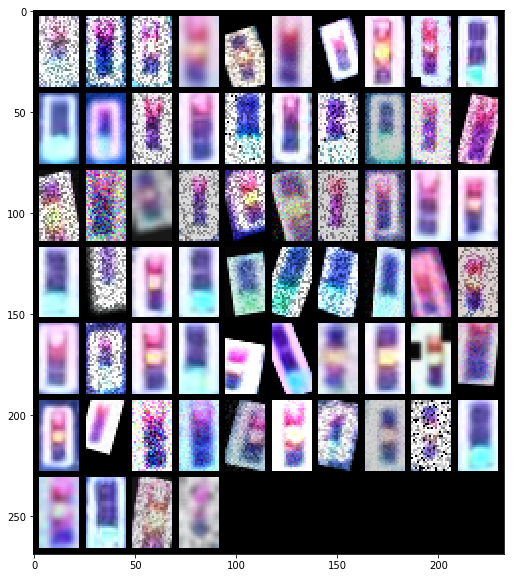

In [5]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize = (20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

batch, classes = next(iter(train_loader))

grid = utils.make_grid(batch, nrow=10, padding=3, scale_each=True)
show(grid)
print(classes)

# Define model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(420, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 420)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
n_epochs = 500
batch_size_train = 256
batch_size_test = 10000
learning_rate = 0.0005
momentum = 0.9
log_interval = 20

train_losses = []
train_counter = []
test_losses = []
accuracy = []
wrong_preds = dict()

In [19]:
network = Net()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [20]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [21]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      # get the indices of wrong answer
      wrong_outputs = (pred.eq(target.data.view_as(pred))==0 ).nonzero().squeeze()
      # amount of wrong prediction per index to get the most difficult images to predict
      for key in wrong_outputs:
        if key.dim == 0:
          key = key[0].item() # it doesn't work when i put .item() in brackets below for some reason
          wrong_preds[key] = wrong_preds.get(key, 0) + 1
#       print("wrong answers:", wrong_preds)
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  accuracy.append(100. * correct.item() / len(val_loader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    accuracy[-1]))
  print(accuracy[-1], type(accuracy[-1]))

  # save only when accuracy is 100%
  if accuracy[-1]==100.0:
    torch.save(network.state_dict(), 'models/model.pth')
    torch.save(optimizer.state_dict(), 'models/optimizer.pth')

In [11]:
test()

/home/mital/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4484, Accuracy: 211/2385 (8.85%)

8.846960167714885 <class 'float'>


In [0]:
n_epochs = 500
# test()
for epoch in range(1, n_epochs+1):
  train(epoch)
  test()

# Single image inference for tests

tensor([[-3.7806e-04],
        [-9.5755e+00],
        [-8.0854e+00],
        [-1.4401e+01]])
0


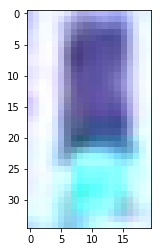

In [26]:
# comment out the following line to use the newly trained model
model = 'models/bestmodel.pth'

if device =='cpu':
    network.load_state_dict(torch.load(model, map_location='cpu')) #
else:
    network.load_state_dict(torch.load(model)) #


img = PIL.Image.open("train_val/val/green/green_10.png")
img = img.resize((20, 35), PIL.Image.ANTIALIAS)
plt.imshow(np.asarray(img))

# convert PIL to torch tensor
img = np.array(img)[...,:3]
img = torch.tensor(img, dtype=torch.float).permute(2,0,1)/255

img = img.unsqueeze(0).to(device)
network.eval()

output = network(img)
# output the probabilities of each class
print(output.data.T)
# output the class number
pred = output.data.max(1, keepdim=True)[1]
print(pred.item())

# Helper functions

'1561556532:83'

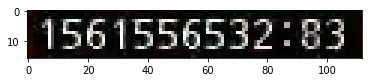

In [29]:
import pytesseract
import PIL.ImageOps as ImageOps
import cv2
import time

# inference single OpenCV image
def single_infer(img):
  #Takes opencv image and classifies the traffic light
  with torch.no_grad():
    # convert to PIL
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = PIL.Image.fromarray(img)
    img = img.resize((20, 35), PIL.Image.ANTIALIAS)
    
    
#     plt.imshow(np.asarray(img))

    # convert to torch tensor
    img = np.array(img)[...,:3]
    img = torch.tensor(img, dtype=torch.float).permute(2,0,1)/255
    img = img.unsqueeze(0).to(device)
    
    # set network to eval mode and infer
    network.eval()
    output = network(img)
    
    pred = output.data.max(1, keepdim=True)[1]
    return pred.item()



def rec_time(img):
    # OCR the timestamp of the video
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = PIL.Image.fromarray(img)

    # without invert the results are poor
    img = PIL.ImageOps.invert(img)
    
    # change format from None to Jpeg otherwise tesseract complains
    img.format = 'JPEG'
    text = pytesseract.image_to_string(img)

    return text

def validate_time(text):

    # small validation step. The main validation is done through another code in the repository
    
    # replace errorenous classification of S with 5
    if ':' in text:
        first_part  = text.split(':')[0].strip().replace('S', '5')
        second_part = text.split(':')[1].strip().replace('S', '5')
        second_part = ''.join(filter(lambda x: x.isdigit(), second_part))
    
    # the OCR sometimes added 7 at the end of the string for some reason, which we cut
    if len(second_part)==3 and second_part.endswith('7'):
      second_part = second_part[:2]

    return first_part+':'+second_part

# test OCR for a single frame
cap = cv2.VideoCapture("videos/test.mp4")
# set the number of the frame
cap.set(1,500)

_, img = cap.read()
img = img[60:76, 142:254]
plt.imshow(img)

rec_time(img)

# Test model inference for a single frame

total number of frames: 2781.0
Frame number: 500.0
right light status: 2


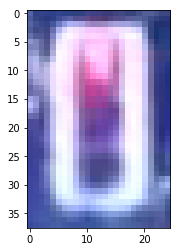

In [30]:
import time
cap = cv2.VideoCapture("videos/test.mp4")
while not cap.isOpened():
    cv2.waitKey(1000)
    print("Wait for the header")
    time.sleep(10)

pos_frame = cap.get(1)
print('total number of frames:', cap.get(7))

left_status, right_status = None, None
last_change = cap.get(1)

cap.set(1,500)
print('Frame number:',cap.get(1))

flag, frame = cap.read()

left_light = frame[50:80, 85:105]
right_light = frame[95:133, 270:295]
timeimg = frame[60:75, 142:250]

plt.imshow(np.asarray(cv2.cvtColor(right_light, cv2.COLOR_BGR2RGB)))

print('right light status:',single_infer(right_light))
right_out = single_infer(right_light)
timestamp = rec_time(timeimg)

In [32]:
import csv
import time

filename = 'test.mp4'

cap = cv2.VideoCapture("videos/"+filename)
while not cap.isOpened():
    cv2.waitKey(1000)
    print("Wait for the header")
    time.sleep(10)

pos_frame = cap.get(1)
print('total number of frames:', cap.get(7))

left_status, right_status = None, None
last_change = cap.get(1)

cap.set(1,500) # skip firt few frames in case bad quality

# cv2_imshow(cap.read()[1])

left_csv = open(filename+'_left.csv', 'w')
right_csv = open(filename+'_right.csv', 'w')

frames_processed = 0

with left_csv, right_csv:
    leftWriter = csv.writer(left_csv)
    rightWriter = csv.writer(right_csv)

    while True:
        flag, frame = cap.read()
        frames_processed +=1
        # Check if image is ready
        if flag:

            # extract images of left and right traffic lights
            left_light = frame[50:80, 85:105]
            right_light = frame[95:133, 270:295]
            timeimg = frame[60:75, 142:250]
            
            # number of frame
            pos_frame = cap.get(1)

            # run the images through the model
            left_out = single_infer(left_light)
            right_out = single_infer(right_light)

    #         print(res)

            # check if traffic lights status changed and save the change
            if left_status != left_out:
              left_status = left_out
    
              timestamp = rec_time(timeimg)
              timestamp_cor = validate_time(timestamp)
              leftWriter.writerow([left_status, timestamp, timestamp_cor])
              print('left:',[left_status, timestamp, timestamp_cor])

            # same for right light
            if (right_status != right_out):
              right_status = right_out
              timestamp = rec_time(timeimg)
              timestamp_cor = validate_time(timestamp)
              rightWriter.writerow([right_status, timestamp, timestamp_cor])
              print('right:',[right_status, timestamp, timestamp_cor])
            
            # print frame number sometimes for orientation
            if frames_processed%500 == 0:
                print("frames processed:",frames_processed)
            
            if frames_processed+100 > cap.get(7):
              break
            
        else:
            # The next frame is not ready, so we try to read it again
            cap.set(1, pos_frame-1)
            print("frame is not ready")
            # It is better to wait for a while for the next frame to be ready
            cv2.waitKey(1000)

        if cv2.waitKey(10) == 27:
            break
        if frames_processed+100 > cap.get(7):
            # If the number of captured frames is equal to the total number of frames,
            # we stop
            break


total number of frames: 2781.0
left: [1, '1561556532:83', '1561556532:83']
right: [2, '1561556532:83', '1561556532:83']
left: [2, '1561556533:79', '1561556533:79']


KeyboardInterrupt: 